<a href="https://colab.research.google.com/github/DeKUT-DSAIL/dsa-2024-nlp/blob/main/post-lab/post_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Post NLP Lab
You can run this notebook after the nlp lab at your own time. It is meant to help you understand the differences between simple representations and LLMs. If you do decide to run it, ensure you have first loaded the reuters dataset from the text cleaning section.

In [ ]:
# Install packages
! pip install contractions
! pip install nltk
! pip install gensim

In [ ]:
# Load dependencies
import numpy as np
import re
import requests
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
from nltk.corpus import gutenberg, stopwords, wordnet
from nltk import FreqDist, word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.util import trigrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter
import spacy
from spacy.tokenizer import Tokenizer
import math
import contractions
from itertools import islice

In [ ]:
# Init spacy
nlp = spacy.load('en_core_web_sm')
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


## Download dataset and set up basic functions

In [ ]:
nltk.download('reuters')
from nltk.corpus import reuters
categories = ['nickel', 'gold', 'silver', 'tea', 'barley', 'fuel', 'crude', 'gas', 'heat']
fields_for_categories = []
docs_per_category = 10
for c in categories:
  fields_for_categories.append(reuters.fileids(c)[0:docs_per_category])


[nltk_data] Downloading package reuters to
[nltk_data]     /Users/andreasd/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [ ]:
def clean_text1(text):
  text = contractions.fix(text) # Fix contractions
  text = text.lower() # lowercase the text
  text = text.replace('\n', ' ') # replace new line characters with whitespace
  text = re.sub(r"[^\w\s']", ' ', text) # Remove non-word characters, except apostroophes - to handle possessives correctly e.g "John's"
  text = text.strip() # Remove extra whitespace

  ## -- Tokenize, lemmatize, remove stopwords -- ##
  doc = nlp(text)
  tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct] # Lemmatize and exclude stopwords
  text = " ".join(tokens)
  # Remove any additional extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return text

## Continuous representations vs TfIDF

In the main lab we discussed word2vec as a continuous representation. Here, let's explore the glove vectors, computed on a dataset from twitter.

In [ ]:
import gensim.downloader as api
model_glove_twitter = api.load("glove-twitter-25")

This model transforms words into continuous representations. It doesn't need to be trained on our dataset because it's trained on a much bigger dataset which is in english. So we hope that since our dataset is also in English, we can use it. Let's test it:

In [ ]:
model_glove_twitter.most_similar('gold')

[('silver', 0.9574297666549683),
 ('blue', 0.9178594946861267),
 ('crown', 0.9062464237213135),
 ('diamond', 0.904084324836731),
 ('green', 0.9032608270645142),
 ('platinum', 0.896143913269043),
 ('black', 0.889187753200531),
 ('crystal', 0.889158308506012),
 ('red', 0.8877547979354858),
 ('white', 0.8857155442237854)]

These are the most similar words to `gold` in the english dataset that the model was trained on.
Let's see if we can train a model on our own corpus and compare the results.

First, let's re-shape our data from Reuters into sentences.

In [ ]:
sentence_data = []
categories_sentence_data = []

for j in range(len(fields_for_categories)):
  for i in reuters.sents(fields_for_categories[j]):
      cur = [tmp for tmp in clean_text1(' '.join(i)).split(' ')]
      # Remove standalone numbers
      cur = [tmp for tmp in cur if not tmp.isnumeric()]
      sentence_data.append(cur)
      categories_sentence_data.append(categories[j])

Now, we will train our own word2vec model. It will be trained only on the small set of Reuters articles we have. This is text of a particular domain (it has to do with trade etc) so the word similarities might now be exactly what you'd expect from "normal" english language! Let's see!

In [ ]:
from gensim.models import Word2Vec
import gensim

In [ ]:
model2 = Word2Vec(min_count=2,window=2, vector_size=50)

In [ ]:
model2.build_vocab(sentence_data, progress_per=10000)

In [ ]:
model2.train(sentence_data, total_examples=len(sentence_data), epochs=200, report_delay=1)

(1562085, 2041200)

In [ ]:
model2.wv.most_similar('gold')

[('bullion', 0.5874730348587036),
 ('item', 0.5840972661972046),
 ('bear', 0.5654229521751404),
 ('deposit', 0.5583978891372681),
 ('nugget', 0.551899254322052),
 ('nicel', 0.5508739948272705),
 ('article', 0.547793447971344),
 ('zurich', 0.5427208542823792),
 ('property', 0.5424924492835999),
 ('hallmarke', 0.5371420383453369)]

Not bad! We see that words like "bear", "zurich" and "purchase" are marked higher than in normal english language, because the training set is from articles of a particular type, related to trade, markets etc. The model does not have knowledge of the english language besides what it has seen in this dataset!

Let's explore a bit more...  

In [ ]:
model2.wv.similarity('new', 'york') # high similarity

0.46009794

In [ ]:
model2.wv.similarity('new', 'yesterday') # low similarity

0.1391531

In [ ]:
model2.wv.similarity('swiss', 'franc') # high similarity

0.7363148

In [ ]:
model2.wv.similarity('swiss', 'tea') # low similarity

0.08821306

That makes sense, hopefully! Remember, this is semantic similarity.  

Now let's create TF-IDF representations of every document in our dataset.

In [ ]:
sentences = [' '.join(i) for i in sentence_data]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter


In [ ]:
count_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer()

# Fit transform on the corpus
X_count_reuters= count_vect.fit_transform(sentences) # count vectorizer
X_tfidf_reuters = tfidf_vect.fit_transform(sentences) # Tfidfvectorizer

# Get the feature names (tokens)
reuters_feat_names_count = count_vect.get_feature_names_out()
reuters_feat_names_tfidf = tfidf_vect.get_feature_names_out()

# Print the feature names
print(f"Reuters CountVectorizer feature names:\n {reuters_feat_names_count}")
print(f"\nReuters TfidfVectorizer feature names:\n {reuters_feat_names_tfidf}")

Reuters CountVectorizer feature names:
 ['1980s' '3rd' 'ability' ... 'zinc' 'zone' 'zurich']

Reuters TfidfVectorizer feature names:
 ['1980s' '3rd' 'ability' ... 'zinc' 'zone' 'zurich']


In [ ]:
print("CountVectorizer document-term matrix:")
print(X_count_reuters.toarray())

print("\nTfidfVectorizer document-term matrix:")
print(X_tfidf_reuters.toarray())


CountVectorizer document-term matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

TfidfVectorizer document-term matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Get the TF-IDF scores for each document
for i in range(len(sentences)):
    tfidf_values = X_tfidf_reuters[i].toarray().flatten()  # TF-IDF values for the i-th document
    max_tfidf_index = tfidf_values.argmax()  # Index of the term with the highest TF-IDF score
    max_tfidf_term = reuters_feat_names_tfidf[max_tfidf_index]  # Term with the highest TF-IDF score
    max_tfidf_score = tfidf_values[max_tfidf_index]  # Highest TF-IDF score
    # print(f"Document {i+1} ({categories_sentence_data[i]}): The term '{max_tfidf_term}' has the highest TF-IDF score of {max_tfidf_score}")

Let's plot the TF-IDF representation of each Reuters article. Because the TFIDF vector is a long (and sparse) vector, to plot it we need to project it to two dimensions. We'll use PCA.

In [ ]:
tmp = np.array([X_tfidf_reuters[i].toarray().tolist()[0] for i in range(len(sentences))])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(2)

#Transform the data
pca_data = pca.fit_transform(tmp)

# from sklearn.manifold import TSNE
# pca_data = TSNE(n_components=2, learning_rate='auto',
                  # init='random', perplexity=3).fit_transform(tmp)


To plot the pca-projected TFIDF vectors, we will color each point according to the category it belongs in the Reuters dataset.

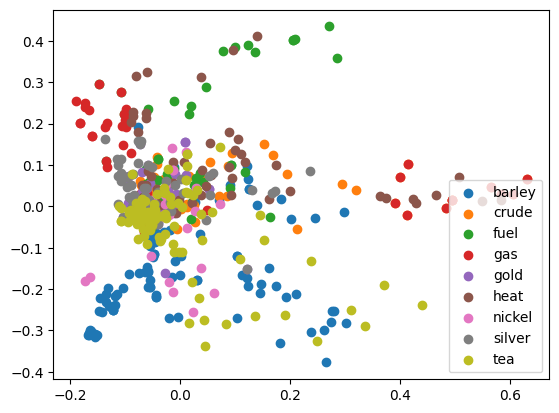

In [ ]:
import matplotlib.pyplot as plt

labels = categories_sentence_data
#Getting unique labels
u_labels = np.unique(labels)

for i in u_labels:
  tmp_ind = []
  for j in range(len(labels)):
    tmp_ind.append(True if labels[j] == i else False)
  plt.scatter(pca_data[tmp_ind , 0] , pca_data[tmp_ind , 1] , label = i)
plt.legend()
plt.show()

The results are OK, but not great. We can see that articles of the same category cluster close to each other (e.g. all the blue points roughly together, most of the red points taking roughly one area in the plot etc).

However, there is also a lot of overlap. This could be because we projected only on two dimensions - with a 3-D plot maybe things could be a bit better separated.

In any case, let us now leverage the power of LLMs and compare again.

## Transformers

    First, let's install `sentence-transformers` from huggingface (link: https://huggingface.co/sentence-transformers).

In [ ]:
!pip install sentence-transformers

Then, we load the library and have to specify a pre-trained model. You can go on the documentation webpage (https://www.sbert.net/docs/sentence_transformer/pretrained_models.html) and explore the various models offered.

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
sentence_transformer_model="paraphrase-MiniLM-L12-v2"
sentence_encoder = SentenceTransformer(sentence_transformer_model)

/Users/andreasd/.pyenv/versions/3.10.4/envs/llms-3.10.4/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


We will further reshape our data such that they can be processed by the transformer, we will have a list of documents.

In [ ]:
document_data = []
categories_document_data = []


for j in range(len(fields_for_categories)):
  for i in reuters.sents(fields_for_categories[j]):
      # cur = [tmp for tmp in clean_text1(' '.join(i)).split(' ')]
      # Remove standalone numbers
      # cur = ' '.join([tmp for tmp in cur if not tmp.isnumeric()])
      document_data.append(' '.join(i))
      categories_document_data.append(categories[j])


In [ ]:
document_data[0]

'NICKEL PRICES UNLIKELY TO RISE MUCH - SHEARSON Nickel prices are unlikely to rise significantly from current levels unless further steps are taken to reduce production , Shearson Lehman Brothers said in its quarterly nickel market report .'

We encode the data using the LLM. This is similar to creating a word vector from word2vec, in that the output is again a continous dense represnetation. However here:
- The model can take sentences as input
- The model is pre-trained on many many data. This means that it distills a lot of `world knowledge`, in addition to "understanding" syntax, grammar etc.

In [ ]:
encoded = sentence_encoder.encode(document_data, show_progress_bar=True)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Now we'll plot again the projected representations for each article (t-SNE is better here).

In [ ]:
# dim_red_data = pca.fit_transform(encoded)
dim_red_data = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(encoded)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


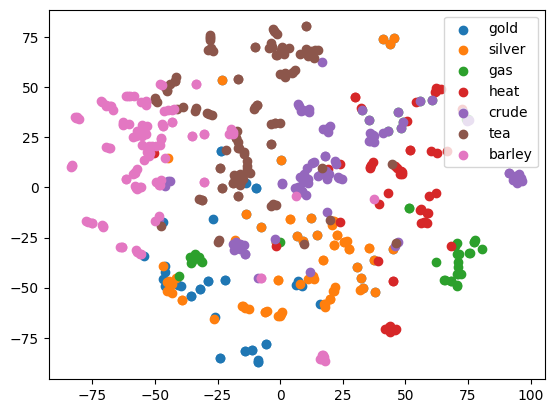

In [ ]:
labels = categories_document_data
#Getting unique labels
u_labels = ['gold', 'silver', 'gas', 'heat', 'crude', 'tea', 'barley' ]

for i in u_labels:
  tmp_ind = []
  for j in range(len(labels)):
    tmp_ind.append(True if labels[j] == i else False)
  plt.scatter(dim_red_data[tmp_ind , 0] , dim_red_data[tmp_ind , 1] , label = i)
plt.legend()
plt.show()

This should look better in terms of separation.

## Exercise: Play with the encoder, be creative!

The sentence encoder is very easy to use and very powerful! You can bring in your own ideas about how to use it. You can consider doing clustering, for example. It can transform long texts into continous sequences, either in batch (as above) or one by one, e.g.

In [ ]:
sentence_encoder.encode('This is my dummy sentence')[0:10]

array([ 0.02957506,  0.10906983, -0.07986979,  0.24416006,  0.2030941 ,
        0.01806907,  0.79616004,  0.22748263,  0.13852295, -0.05697105],
      dtype=float32)